In [205]:
import cv2
import numpy as np
import albumentations as A
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, 
    ShiftScaleRotate, MotionBlur, MedianBlur, Blur , 
)
import random
import os
import matplotlib.pyplot as plt
import cvzone
from cvzone.SelfiSegmentationModule import SelfiSegmentation
from PIL import Image



IMAGE_HEIGHT,IMAGE_WIDTH = 220, 340
CLASSES_LIST = ['away','map','photo','trap','son','where','breakfast','deaf','bright']
number_of_augmentations = 8
data_dir = os.path.join('datasets','argentinian')

In [3]:
def delete_non_images(directory):
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')): 
            try:
                img = Image.open(os.path.join(directory, filename)) 
                img.verify() 
            except (IOError, SyntaxError) as e:
                print('Bad file:', filename)
                os.remove(os.path.join(directory, filename))
        else:
            os.remove(os.path.join(directory, filename))

delete_non_images('backgrounds')


In [258]:
segmentor = SelfiSegmentation(model=0)
backgrounds = np.array([img for img in os.listdir('backgrounds')])

def set_background():
    path = np.random.choice(backgrounds)
    back = cv2.imread(f'backgrounds/{path}')
    back = cv2.resize(back,(IMAGE_WIDTH,IMAGE_HEIGHT))
    
    return back

def replace_background(image,back):

    segmented_image = segmentor.removeBG(image,back,cutThreshold=0.5)
    
    return segmented_image

In [5]:
backgrounds.shape

(3277,)

In [274]:

# Define the augmentation pipeline
transform = A.ReplayCompose([
    # A.HorizontalFlip(p=0.5),
    # A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0, scale_limit=0, rotate_limit=5, p=1.0,border_mode=cv2.BORDER_REPLICATE),
    A.OneOf([
        A.CenterCrop(height=(IMAGE_HEIGHT-40),width=(IMAGE_WIDTH-90),p=1.0),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.1, rotate_limit=0, p=1.0,border_mode=cv2.BORDER_CONSTANT)
    ],p=1),
    # A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.4, p=.6),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=.1),
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH,p=1.0)
])

def load_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame,(IMAGE_WIDTH,IMAGE_HEIGHT))
        frames.append(frame)
    cap.release()
    return frames

def save_video(frames, output_path):
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 30.0, (width, height))
    for frame in frames:
        out.write(frame)
    out.release()


def augment_video_frames(frames):
    augmented_frames = []
    
    back = set_background()
    
    replay = None
    for frame in frames:
        # Apply the augmentations
        if replay is None:
            augmented = transform(image=frame)
            replay = augmented['replay']
        else:
            augmented = A.ReplayCompose.replay(replay, image=frame)
        
        # gray = np.expand_dims(cv2.cvtColor(augmented['image'],cv2.COLOR_BGR2GRAY),axis=2)
        segmented_image = replace_background(augmented['image'],back)
       
        augmented_frames.append(segmented_image)

    return augmented_frames

def process_video(video_path, output_path):
    # Load video
    video = load_video(video_path)

    # Augment video
    video_aug = augment_video_frames(video)

    # Save video
    save_video(video_aug, output_path)
    
    return np.array(video_aug)



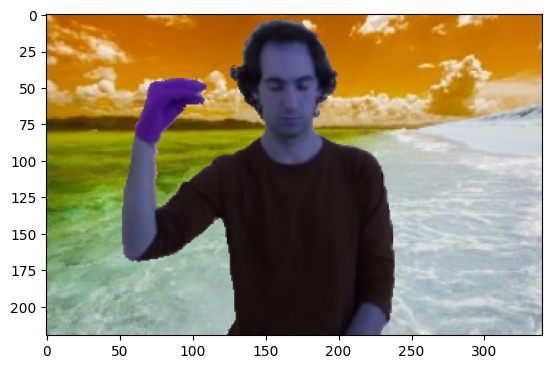

In [281]:
image = (process_video(f'{data_dir}/away/013_001_005.mp4',f'datasets/1.mp4'))[20]
plt.imshow(image,cmap='gray')

In [253]:
os.makedirs('datasets/Augmented2',exist_ok=True)

for sign in CLASSES_LIST:
    counter = 1
    os.makedirs(f'datasets/Augmented2/{sign}',exist_ok=True)
    for video in os.listdir(f'{data_dir}/{sign}'):
        for aug in range(number_of_augmentations):
            process_video(f'{data_dir}/{sign}/{video}',f'datasets/Augmented2/{sign}/{counter}.mp4')
            counter+=1